## HB_FakeData
A test file for testing hierarchical bayes and generating data from an RL relationship

HM 2/3

Updated 7/3

In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpy as np
from chainconsumer import ChainConsumer
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
numpyro.set_host_device_count(1)
jax.config.update('jax_platform_name', 'cpu')

### Mock Contours
Instead of going through the expensive process of generating mock DRW data and modelling as a gaussian process, we just use a mock-up of the sort of contours we get in $\Delta t_1$-$\Delta t_2$ space:

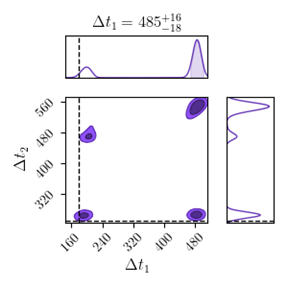

In [2]:
def fake_LL(lagtrue, alias_width = 30, true_width = 30, rel_height = 1):
    #This returns the likelihood function in lag-lag space with aliasing peaks and the true peak
    xtrue, ytrue = lagtrue

    def outfunc(x,y):
        out = 0
        for i in [0,1]:
            for j in [0,1]:
                dx = x - (180 + 360*i)
                dy = y - (180 + 360*j)
                r2 = dx**2 + dy**2
                out += jnp.exp(-r2/alias_width**2/2)

        r2 = (x - xtrue)**2 + (y - ytrue)**2
        out+= jnp.exp(-r2/true_width**2/2) * rel_height
        return(out)
    return(outfunc)

Now confirm this is working by plotting the contours for some example:

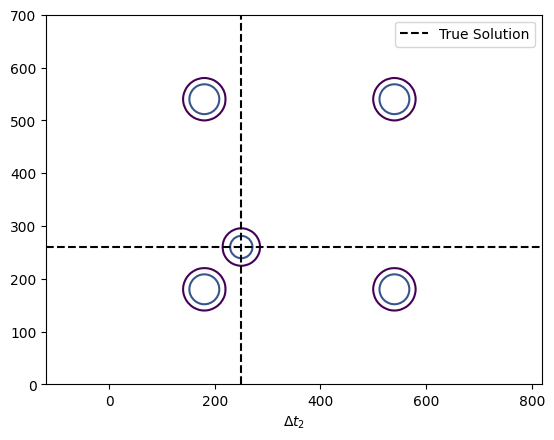

In [3]:
lagtrue = [250, 260]
f = fake_LL(lagtrue = lagtrue, alias_width = 20, rel_height= np.random.rand()*0.5+0.5, true_width= 20)

scanrange = jnp.linspace(0,700, 128)
X,Y = jnp.meshgrid(scanrange, scanrange)
Z = f(X,Y)

plt.contour(X,Y,Z, levels = np.max(Z)*np.exp([-2,-1,0]))
plt.axvline(lagtrue[0], c='k',ls='--', label='True Solution')
plt.axhline(lagtrue[1], c='k',ls='--')
plt.axis('equal')
plt.xlabel("$\Delta t_1$")
plt.xlabel("$\Delta t_2$")
plt.legend(loc="best")
plt.show()

Now we see how well numpyro recovers this with sampling. Because this is a multi-model distribution, we need to use many chains with a random set of initial starting points.

In [4]:
init_lags = [250,260]
true_lags = [250,200]

potential_func = fake_LL(lagtrue = true_lags, alias_width = 10, rel_height= np.random.rand()*0.5+0.5, true_width= 10)

def model():

    x = numpyro.sample('lag_1', numpyro.distributions.Uniform(0,600))
    y = numpyro.sample('lag_2', numpyro.distributions.Uniform(0,600))

    numpyro.factor('log_pot', jnp.log( potential_func(x,y) + 1E-15 ) ) #Add buffer to avoid log-zero issues which mess with some samplers

In [5]:
#Possible Sampler Types

sampler_type = numpyro.infer.NUTS
#sampler_type = numpyro.infer.SA
#sampler_type = numpyro.infer.BarkerMH

#Ways to initialize
init_strat = init_strategy=numpyro.infer.init_to_uniform()
#init_strat  =numpyro.infer.init_to_value(values = {'lag_1': init_lags[0], 'lag_2': init_lags[1]})

print("Beginning sampling...")
sampler = numpyro.infer.MCMC(
    sampler_type(model = model, init_strategy=init_strat),
    num_warmup=100,
    num_samples=100,
    num_chains=50,
    progress_bar=False,
    chain_method = 'sequential',
)
sampler.run(jax.random.PRNGKey(10))
print("Done")

Beginning sampling...
Done


Now plot this as a chainconsumer plot

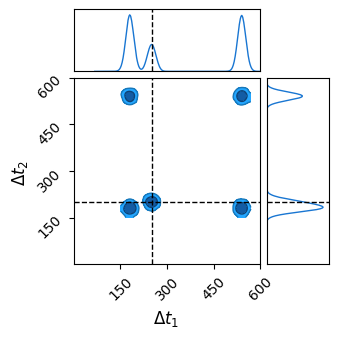

In [6]:
output = sampler.get_samples()
c = ChainConsumer()
c.add_chain([output['lag_1'], output['lag_2']], parameters=['$\Delta t_1$','$\Delta t_2$'])

c.plotter.plot(truth=true_lags, extents={"$\Delta t_1$": (0,600), "$\Delta t_2$": (0,600)})

plt.show()

### Use of Priors
Try the above again, but this time adjusting the model so that the two lags are within 10% of eachother

In [7]:
def model_withpriors():

    x = numpyro.sample('lag_1', numpyro.distributions.Uniform(0,600))
    y = numpyro.sample('lag_2', numpyro.distributions.Uniform(0,600))

    numpyro.factor('log_pot', jnp.log( potential_func(x,y) + 1E-15 ) ) #Add buffer to avoid log-zero issues which mess with some samplers
    numpyro.sample('lagsim', numpyro.distributions.Normal(1,0.1), obs = y/x)
    
print("Beginning sampling...")
sampler_withpriors = numpyro.infer.MCMC(
    sampler_type(model = model_withpriors, init_strategy=init_strat),
    num_warmup=100,
    num_samples=100,
    num_chains=50,
    progress_bar=False,
    chain_method = 'sequential',
)
sampler_withpriors.run(jax.random.PRNGKey(10))
print("Done")

Beginning sampling...
Done


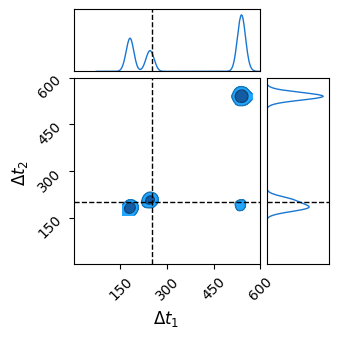

In [8]:
output_withpriors = sampler_withpriors.get_samples()
c_withpriors = ChainConsumer()
c_withpriors.add_chain([output_withpriors['lag_1'], output_withpriors['lag_2']], parameters=['$\Delta t_1$','$\Delta t_2$'])

c_withpriors.plotter.plot(truth=true_lags, extents={"$\Delta t_1$": (0,600), "$\Delta t_2$": (0,600)})

plt.show()

### Mockup Population Data

Here we generate a population of many sources based on R-L relationships and lag similarity.
<center>
    $\begin{align}
    log|\Delta t_1| \sim N(\alpha_1 \cdot log|L| + \beta _1, \Delta t_1)
    \\ log|\Delta t_2| \sim N(\alpha_2 \cdot log|L| + \beta _2, \Delta t_2)
    \end{align}$
</center>


And lag similarity, $\Delta t_1 \approx \Delta t_2$, is describe as either:

<center>
    $\begin{align}
    \frac{\Delta t_2}{\Delta t_1} \sim N(\gamma, \Delta_\gamma)
    \\Or
    \\ {\Delta t_2}-{\Delta t_1} \sim N(\gamma -1 , \Delta_t)
    \end{align}$
</center>

Here using:
<center>
    $\begin{align}
    \alpha_i = 0.5
    \\ \beta_i = 0.5
    \\ \Delta_i = 1.0
    \\ \gamma = 0.5
    \\ \Delta _ \gamma = 0.25
    \end{align}$
</center>

In [9]:
def makelags(L, params=None):
    default_params = {
        "alpha_RL": [0.5,     0.5],
        "beta_RL":  [0.5,     0.5],
        "delta_RL": [0.5*2,   0.5*2],

        "gamma":       1,
        "delta_gamma": 0.25,
        "delta_t":     20,
        
        "lagsim_mode": "None"
    }
    
    #Overwrite defaults /w input
    if params!=None:
        for key in params.keys():
            default_params[key] = params[key]
    
    #Unpack vals
    alpha_RL    = default_params["alpha_RL"]
    beta_RL     = default_params["beta_RL"]
    delta_RL    = default_params["delta_RL"]
    gamma       = default_params["gamma"]
    delta_gamma = default_params["delta_gamma"]
    delta_t     = default_params["delta_t"]
    lagsim_mode = default_params["lagsim_mode"]

    #=========================================================
    N=len(L)
    #Make initial raft of lags
    lags_1 = np.exp(alpha_RL[0]*np.log(L) + beta_RL[0]+ np.random.normal(size=N)*delta_RL[0])
    lags_2 = np.exp(alpha_RL[1]*np.log(L) + beta_RL[1]+ np.random.normal(size=N)*delta_RL[1])

    #If also using lag similarity:
    if lagsim_mode == "prop" or lagsim_mode == "band":
        norm = 1
        good_to_go = np.exp(-(((lags_1 / lags_2) - gamma) / delta_gamma)**2 / 2) / np.sqrt(2*np.pi*delta_gamma) > np.random.rand(N)

        while False in good_to_go:
            #Indices of cells that need to be updated
            inds = np.where(good_to_go==False)[0]

            #Re-roll required cells
            lags_1[inds] = np.exp(alpha_RL[0]*np.log(L[inds]) + beta_RL[0])+ np.random.normal(size=len(inds))*delta_RL[0]
            lags_2[inds] = np.exp(alpha_RL[1]*np.log(L[inds]) + beta_RL[1])+ np.random.normal(size=len(inds))*delta_RL[1]

            #Use proportionality or linear relationship
            if lagism_mode=="prop":
                dex = (( (lags_2[inds] / lags_1[inds]) - gamma) / delta_gamma)**2
            else:
                dex = ( (lags_2[inds]*gamma - lags_1[inds]*(gamma-1)) / delta_t)**2

            #Check if updated cells are good or need another pass
            good_to_go[inds] = np.exp(-dex/2) / norm > np.random.rand(len(inds))

    return(lags_1,lags_2)

In [10]:
#Actually generate the lags
Nsources = 1000
Lmin = 1
Lmax = 1000
L = np.exp(np.random.uniform(low = np.log(Lmin), high = np.log(Lmax), size=Nsources)) # Log Uniform Dist
#L = np.random.uniform(low = Lmin, high = Lmax, size=Nsources) # Uniform

params = {
    #R-L Slopes, Offsets & Spreads
    "alpha_RL": [0.5,     0.5],
    "beta_RL":  [0.5,     0.5],
    "delta_RL": [0.5*2,   0.5*2],

    #Similarity band left and right
    "gamma":       1,
    "delta_gamma": 0.25,
    "delta_t":     20,

    "lagsim_mode": "band"
}
lags = makelags(L, params)

print("Lags generated")

NameError: name 'lagism_mode' is not defined

Now plot the population

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].scatter(lags[0],lags[1], s=5, alpha=0.5)
if lagsim_prop:
    ax[0].axline([0,0], slope = gamma)
    ax[0].axline([0,0], slope = gamma+delta_gamma , ls='--')
    ax[0].axline([0,0], slope = gamma-delta_gamma, ls='--')
else:
    ax[0].axline([0,0], slope = gamma)
    ax[0].axline([0,delta_t], slope = gamma , ls='--')
    ax[0].axline([0,-delta_t], slope = gamma, ls='--')

ax[0].axis('equal')

ax[0].axvline( np.exp(np.log(Lmin)*alpha_RL[0] + beta_RL[0]), ls=':')
ax[0].axhline( np.exp(np.log(Lmin)*alpha_RL[1] + beta_RL[1]), ls=':')
ax[0].axvline( np.exp(np.log(Lmax)*alpha_RL[0] + beta_RL[0]), ls=':')
ax[0].axhline( np.exp(np.log(Lmax)*alpha_RL[1] + beta_RL[1]), ls=':')

plotspace = np.linspace(Lmin,Lmax, 2)
for i in [1,2]:
    ax[i].scatter(L,lags[i-1], s=5, alpha=0.5)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

    ax[i].plot( plotspace, np.exp(np.log(plotspace) * alpha_RL[i-1] + beta_RL[i-1]), c='k', ls='-')
    ax[i].plot( plotspace, np.exp(np.log(plotspace) * alpha_RL[i-1] + beta_RL[i-1] - delta_RL[i-1]), c='k', ls='--')
    ax[i].plot( plotspace, np.exp(np.log(plotspace) * alpha_RL[i-1] + beta_RL[i-1] + delta_RL[i-1]), c='k', ls='--')

    ax[i].axvline(Lmin, ls=':')
    ax[i].axvline(Lmax, ls=':')

fig.suptitle("Population True Values, N=%i" %Nsources)
ax[0].set(xlabel='$\Delta t_1$', ylabel='$\Delta t_2$')
ax[1].set(xlabel='$log|L|$', ylabel='$\Delta t_1$')
ax[2].set(xlabel='$log|L|$', ylabel='$\Delta t_2$')

plt.show()
print("Plotting Done")